In [2]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spreads = pd.read_pickle('../data/spreads.pkl')
mean = spreads.mean()

def calibrate_ou():
    # assuming long-term mean is the same
    # the short term mean of our sample

    thetas = []
    for index, x in enumerate(spreads):
        if index == 0:
            continue

        prev_x = spreads[index - 1]

        theta = (-x + prev_x) / (math.e * (prev_x - mean))
        thetas.append(theta)

        return thetas


def log(n):
    abs_n = abs(n)
    if n < 0:
        return math.log(abs_n)
    elif n == 0:
        return 0

    return math.log(abs_n)


thetas = calibrate_ou()
d = list(map(lambda t: log(t), thetas))

data = pd.DataFrame(data=thetas[0:200])
sns.lineplot(data=data).set(title='OU Process Thetas')

theta = sum(thetas) / len(thetas)
print(f'theta: {theta}')
print(f'mean: {mean}')

# calculate variance
variance = spreads.var()
print(f'variance: {variance}')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/spreads.pkl'

Let's calibrate an OU process on the spreads between NASDAQ:AMGN and NASDAQ:VOD, using the following
$$
\Delta X_{t} = \theta \left ( \mu(t) - X_{t} \right )+ \sigma \Delta W_{n} \\
Y_{t} = - \theta X_{t} + \sigma \Delta W_{n} \\
Y_{t} = \beta X_{t} + \alpha + \epsilon_{t}
$$

In [3]:
import ou
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm

DATA_BASE = '../data/nasdaq/'

amgn_df_path = os.path.join(DATA_BASE, 'AMGN.pkl')
amgn_df = pd.read_pickle(amgn_df_path)

vod_df_path = os.path.join(DATA_BASE, 'VOD.pkl')
vod_df = pd.read_pickle(vod_df_path)

# spreads
xt = amgn_df[0] - vod_df[0]
print(xt)

mean_coeff, mean_intercept, theta, sigma = ou.calibrate(xt)

print(f'mu(t) = {mean_coeff}t + {mean_intercept}')
print(f'theta = {theta}')
print(f'sigma = {sigma}')

0       0.000000
1       0.017615
2       0.008398
3      -0.006494
4       0.025322
          ...   
2511    2.223280
2512    2.260589
2513    2.263912
2514    2.293468
2515    2.293036
Name: 0, Length: 2516, dtype: float64
mu(t) = 0.0007700202325885363t + 0.15611717049039653
theta = 0.01553369156702749
sigma = 0.02529951552692011


/home/filiptoth/source/ornstein-uhlenbeck/src/ou.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_coeff = res.params[1]
/home/filiptoth/source/ornstein-uhlenbeck/src/ou.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_intercept = res.params[0]


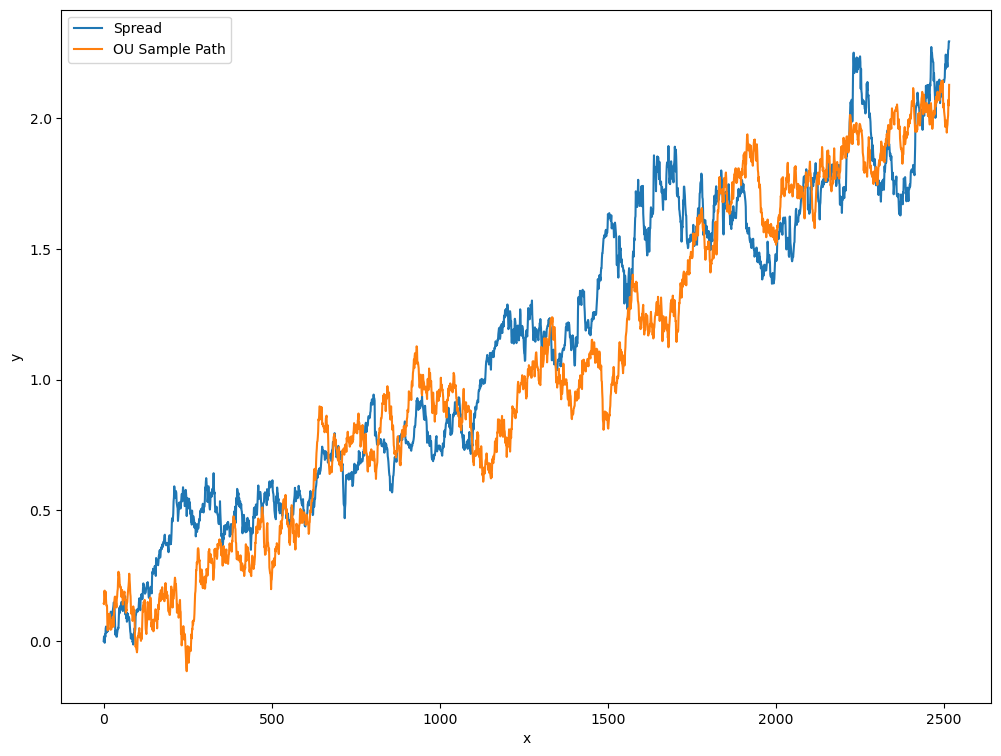

In [5]:
# simulate an OU process

def mean(t):
    return t * mean_coeff + mean_intercept

rng = np.random.default_rng()
def ou_process(t_max, x0):
    value = x0

    values = []
    for t in range(t_max):
        drift = theta * (mean(t) - value)
        wiener = 1 * rng.normal(0, sigma)

        value += drift + wiener
        values.append(value)

    return values


spreads = amgn_df - vod_df
sim_len = len(spreads)
process_values = ou_process(sim_len, mean_intercept)

proc_df = pd.DataFrame({
    'x': range(sim_len),
    'y': process_values
})

spreads_df = pd.DataFrame({
    'x': range(sim_len),
    'y': spreads[0]
})

plt.figure(figsize=(12, 9))

sns.lineplot(data=spreads_df, x='x', y='y', legend="full", label="Spread")
sns.lineplot(data=proc_df, x='x', y='y', label="OU Sample Path")

plt.show()